In [1]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
fast = 10
mid = 20
slow = 30

This time we're starting with three SMAs.

In [3]:
def create_strat_data(yf_data, fast, mid, slow):
    data = yf_data.copy()
    data.columns = data.columns.droplevel(1)
    
    data['FastSMA'] = data['Close'].rolling(window=fast).mean()
    data['MidSMA'] = data['Close'].rolling(window=mid).mean()
    data['SlowSMA'] = data['Close'].rolling(window=slow).mean()

    data['Strategy'] = 0 

    long  = (data['FastSMA'] > data['MidSMA']) & (data['MidSMA'] > data['SlowSMA'])
    short = (data['FastSMA'] < data['MidSMA']) & (data['MidSMA'] < data['SlowSMA'])
    
    data.loc[long,  'Strategy'] = 1
    data.loc[short, 'Strategy'] = 0

    data['Strategy'] = data['Strategy'].shift(1)

    # s = data['Strategy'] # Forward filling on long positions
    # data['Strategy'] = (
    #     s.where(s != 0)
    #      .mask(s == -1, -1)
    #      .ffill()
    #      .fillna(0)
    #      .shift(1)
    # )   
    
    data['Strategy_Returns'] = (1 + data['Close'].pct_change() * data['Strategy']).cumprod() - 1
    data['Asset_Returns'] = (1 + data['Close'].pct_change()).cumprod() - 1

    return data

Here I've created conditions for going long and short. For a long position all faster SMAs must be above all slower SMAs. The inverse should be true for short positions.

Edit: For now I've disabled short positions as after some experiemntation they almost never create a positive impact. I think this is because drawdowns are often quite short and over the past 10 years SPY generally trends upwards creating a sort of bias. For another iteration I might try having different lengths for signaling long positions and short positions. I beleive that shorter length for short SMA indicators will work a little better as they won't lag so much. 

In [4]:
yf_ticker_data = yf.download('SPY', period='10y', interval='1d') 
data = create_strat_data(yf_ticker_data, fast, mid, slow)

[*********************100%***********************]  1 of 1 completed


In [5]:
plot_data = data.dropna()
plot_data

Price            Close        High         Low        Open     Volume  \
Date                                                                    
2016-02-23  162.998596  164.693673  162.879928  164.422455  111455300   
2016-02-24  163.744415  164.024105  160.455975  161.566248  150812200   
2016-02-25  165.727661  165.736145  163.430839  164.193619  110728300   
2016-02-26  165.346252  166.693835  165.185218  166.600619  129833700   
2016-02-29  164.049545  166.312471  163.854615  165.363233  125918100   
...                ...         ...         ...         ...        ...   
2026-01-05  687.719971  689.429993  686.380005  686.539978   71927200   
2026-01-06  691.809998  692.320007  687.780029  687.929993   69273800   
2026-01-07  689.580017  693.960022  689.320007  692.190002   75588300   
2026-01-08  689.510010  690.619995  687.489990  688.820007   64019200   
2026-01-09  694.070007  695.309998  689.179993  690.630005   66133130   

Price          FastSMA      MidSMA     SlowSMA  Strategy  Strategy_Returns  \
Date                                                                         
2016-02-23  160.527144  160.832269  160.698364       0.0          0.000000   
2016-02-24  161.185686  160.959399  160.729155       0.0          0.000000   
2016-02-25  162.056111  161.273413  160.782269       1.0          0.012112   
2016-02-26  163.092654  161.526823  160.959120       1.0          0.009783   
2016-02-29  163.680002  161.520043  161.005170       1.0          0.001863   
...                ...         ...         ...       ...               ...   
2026-01-05  686.173999  682.999088  679.618650       1.0          1.079084   
2026-01-06  687.295996  683.406097  680.992065       1.0          1.091449   
2026-01-07  687.770996  683.804303  682.075120       1.0          1.084707   
2026-01-08  687.925995  684.228424  682.833462       1.0          1.084496   
2026-01-09  688.294995  684.654709  683.534753       1.0          1.098281   

Price       Asset_Returns  
Date                       
2016-02-23       0.001093  
2016-02-24       0.005673  
2016-02-25       0.017854  
2016-02-26       0.015511  
2016-02-29       0.007547  
...                   ...  
2026-01-05       3.223788  
2026-01-06       3.248907  
2026-01-07       3.235212  
2026-01-08       3.234782  
2026-01-09       3.262788  

[2486 rows x 11 columns]

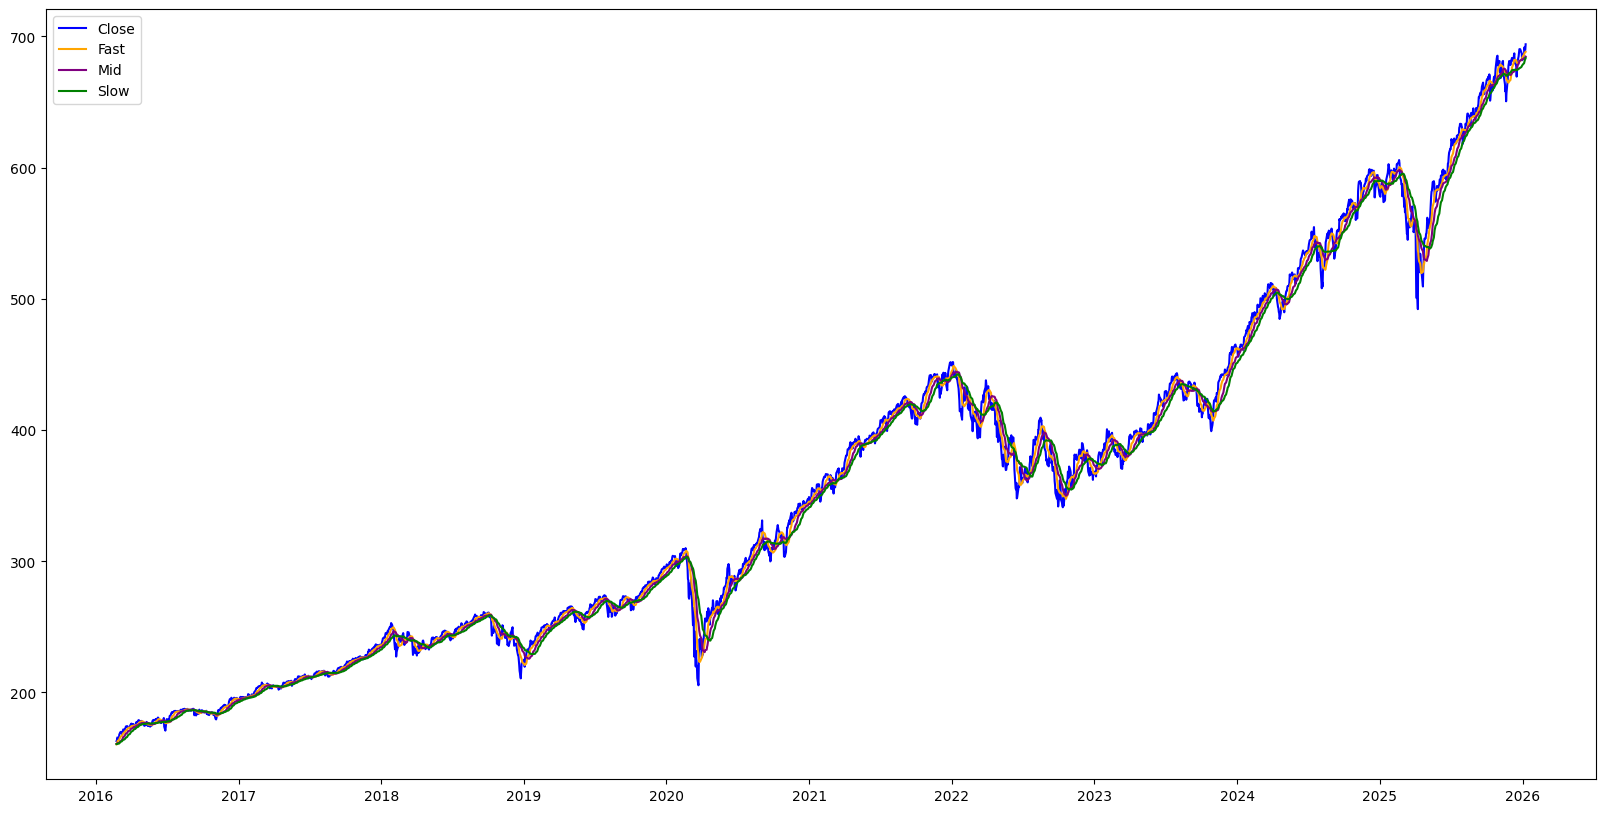

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(plot_data['Close'], color='blue', label='Close')
ax.plot(plot_data['FastSMA'], color='orange', label='Fast')
ax.plot(plot_data['MidSMA'], color='purple', label='Mid')
ax.plot(plot_data['SlowSMA'], color='green', label='Slow')
ax.legend()
plt.show()

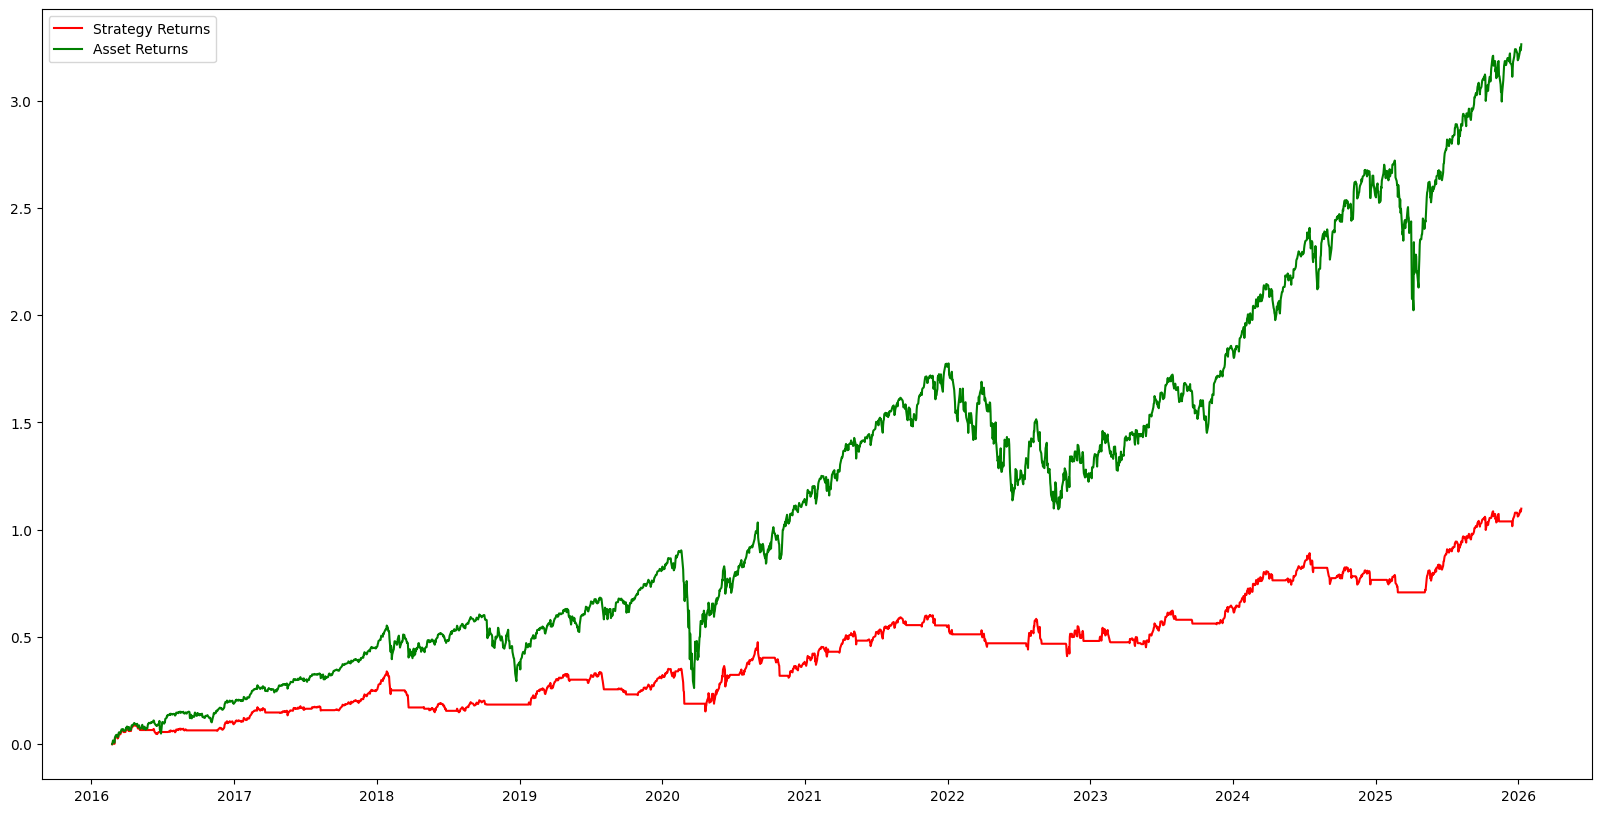

In [8]:

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(plot_data['Strategy_Returns'], color='Red', label='Strategy Returns')
ax.plot(plot_data['Asset_Returns'], color='Green', label='Asset Returns')
ax.legend()
plt.show()

Again this strategy doesn't seem to produce very good returns. However, I haven't tested with any other lengths. To find the best lengths for this particular chart I am going to iterate through each possible combination of SMA lengths and log which creates the largest returns.

In [16]:
lengths = []
for fast in range (0, 100+1):
    for mid in range (0 + fast, 100+1):
        for slow in range (0 + mid, 100+1):
            lengths.append((fast, mid, slow))

In [18]:
results = []
print(len(lengths))
for i in range(len(lengths)):
    length = lengths[i]
    fast = length[0]
    mid = length[1]
    slow = length[2]

    curr_data = create_strat_data(yf_ticker_data, fast, mid, slow)
    returns = curr_data.iloc[-1]['Strategy_Returns']
    results.append([fast, mid, slow, returns])  
    
    print(f"{i / len(lengths) * 100}%")



176851
0.0%
0.0005654477498006797%
0.0011308954996013594%
0.001696343249402039%
0.002261790999202719%
0.002827238749003398%
0.003392686498804078%
0.003958134248604758%
0.004523581998405438%
0.005089029748206117%
0.005654477498006796%
0.006219925247807476%
0.006785372997608156%
0.0073508207474088354%
0.007916268497209515%
0.008481716247010194%
0.009047163996810876%
0.009612611746611554%
0.010178059496412234%
0.010743507246212914%
0.011308954996013592%
0.011874402745814274%
0.012439850495614952%
0.013005298245415632%
0.013570745995216313%
0.01413619374501699%
0.014701641494817671%
0.015267089244618351%
0.01583253699441903%
0.01639798474421971%
0.016963432494020388%
0.017528880243821068%
0.01809432799362175%
0.01865977574342243%
0.019225223493223108%
0.019790671243023788%
0.020356118992824468%
0.020921566742625148%
0.021487014492425828%
0.022052462242226505%
0.022617909992027185%
0.023183357741827868%
0.023748805491628548%
0.024314253241429228%
0.024879700991229905%
0.025445148741030585%


KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(results, columns=["Fast", "Mid", "Slow", "Return"])
best_lengths = results_df.sort_values(by=["Return"], ascending=False).iloc[0]
best_lengths

Here we can see 3, 7 and 14 wouldv'e produced the best returns in the past.

In [ ]:
fast = int(best_lengths["Fast"])
mid = int(best_lengths["Mid"])
slow = int(best_lengths["Slow"])

In [ ]:
data = create_strat_data(yf_ticker_data, fast, mid, slow)
plot_data = data.dropna()
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(plot_data['Strategy_Returns'], color='Red', label='Strategy Returns')
ax.plot(plot_data['Asset_Returns'], color='Green', label='Asset Returns')
ax.legend()
plt.show()



As a last little experiement I want to try the same strategy of finding the best SMA lengths but specifically for shorting. Perhaps afterwards we can see if the two strategies work well together.

In [13]:
def create_short_strat_data(yf_data, fast, mid, slow):
    data = yf_data.copy()
    data.columns = data.columns.droplevel(1)
    
    data['FastSMA'] = data['Close'].rolling(window=fast).mean()
    data['MidSMA'] = data['Close'].rolling(window=mid).mean()
    data['SlowSMA'] = data['Close'].rolling(window=slow).mean()

    data['Strategy'] = 0 

    long  = (data['FastSMA'] > data['MidSMA']) & (data['MidSMA'] > data['SlowSMA'])
    short = (data['FastSMA'] < data['MidSMA']) & (data['MidSMA'] < data['SlowSMA'])
    
    data.loc[long,  'Strategy'] = 0
    data.loc[short, 'Strategy'] = -1

    data['Strategy'] = data['Strategy'].shift(1)

    data['Strategy_Returns'] = (1 + data['Close'].pct_change() * data['Strategy']).cumprod() - 1
    data['Asset_Returns'] = (1 + data['Close'].pct_change()).cumprod() - 1

    return data

In [ ]:
short_results = []

for i in range(len(lengths)):
    length = lengths[i]
    fast = length[0]
    mid = length[1]
    slow = length[2]

    curr_data = create_short_strat_data(yf_ticker_data, fast, mid, slow)
    returns = curr_data.iloc[-1]['Strategy_Returns']
    short_results.append([fast, mid, slow, returns])  

    if i % (len(lengths)/100) == 0:
        print(f"{i / len(lengths) * 100}%")


0.0%


In [ ]:
short_results_df = pd.DataFrame(short_results, columns=["Fast", "Mid", "Slow", "Return"])
short_best_lengths = short_results_df.sort_values(by=["Return"], ascending=False).iloc[0]
short_best_lengths

In [ ]:
fast = int(short_best_lengths["Fast"])
mid = int(short_best_lengths["Mid"])
slow = int(short_best_lengths["Slow"])

In [ ]:
data = create_short_strat_data(yf_ticker_data, fast, mid, slow)
plot_data = data.dropna()
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(plot_data['Strategy_Returns'], color='Red', label='Strategy Returns')
ax.plot(plot_data['Asset_Returns'], color='Green', label='Asset Returns')
ax.legend()
plt.show()

What?